# Bootstrap example

1. Bootstrap the entire dataset
2. Parse ranking by accordance
3. Parse ranking by seasonality

In [61]:
import pandas as pd
import sys
import random
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import numpy as np

from NcReader import *
from Experiment import *
from Stats import *

import warnings
warnings.simplefilter("ignore") 

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams["font.size"] = "16"

palette = ["#1CE1CE", "#008080", "#F3700E", "#F50B00", "#59473C"]


In [70]:
oct = 'OCT_NWT.toml' 
sep = 'SEP_KDI.toml'

e = Experiment('/home/hma000/accomatic-web/tests/test_data/toml/%s' % oct)

df = e.mod().join(e.obs()).dropna()
df = df.groupby(['time']).mean()
df['ens'] = df[['era5','merr','jra5']].mean(axis=1)


# Plotting timeseries visualization of data

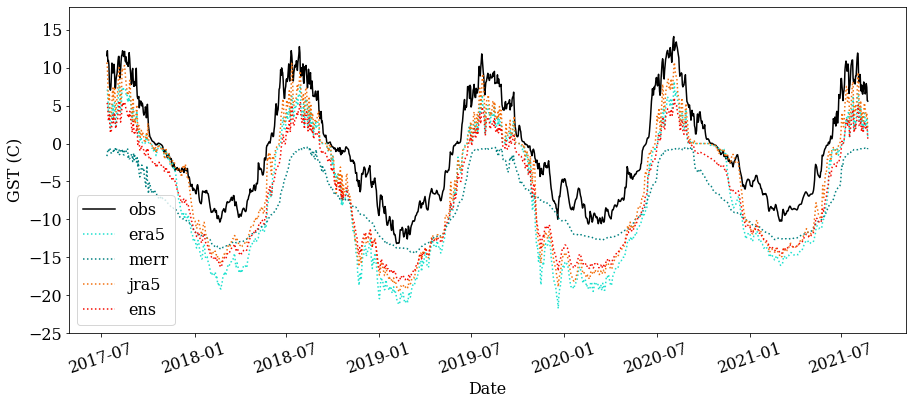

In [63]:
fig, ax = plt.subplots(figsize=(15, 6))

models = ['era5','merr','jra5', 'ens']

plt.rcParams["font.size"] = "16"

plt.plot(df.index, df['obs'], 'k', label='obs')
for mod, i in zip(models, range(len(models))):
    plt.plot(df.index, df[mod], ':', color=palette[i], label=mod)

# Set title and labels for axes
ax.set(xlabel="Date", ylabel="GST (C)")
plt.ylim((-25,18))
plt.legend()
plt.xticks(rotation = 18)
plt.show()

# Setting up bootstrap experiment

In [23]:

def boot(df, boot_size=10000, consecutive_days_slice=5):
    b_rmse, b_will, b_bias = [], [], []
    nrows = range(df.shape[0])

    for i in range(boot_size):
        # Select 5 consecutive days 
        ix = random.randint(nrows.start, nrows.stop-consecutive_days_slice)
        a = df.iloc[ix:ix+consecutive_days_slice, :]
        b_rmse.append(mean_squared_error(a['obs'], a['ens'], squared=False))
        b_will.append(willmott_refined_d(a['ens'], a['obs']))
        b_bias.append(bias(a['obs'], a['ens']))
        
    
    return [np.array(b_rmse), np.array(b_will), np.array(b_bias)]

b_res = boot(df) #(3, 1000)
for i in range(len(b_res)):
    b_res[i] = sorted(b_res[i])
    b_res[i] = b_res[i][25:995]

Text(0.5, 0.98, 'Bootstrap results for ensemble simulation of KDI sites (t=10 days)')

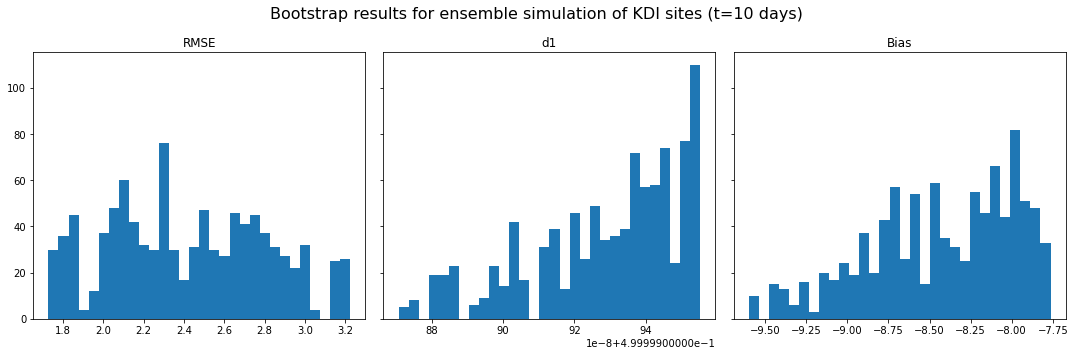

In [29]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(15, 5))
# We can set the number of bins with the *bins* keyword argument.
n_bins = 30
axs[0].hist(b_res[0], bins=n_bins)
axs[0].set_title('RMSE')
axs[1].hist(b_res[1], bins=n_bins)
axs[1].set_title('d1')
axs[2].hist(b_res[2], bins=n_bins)
axs[2].set_title('Bias')

fig.suptitle('Bootstrap results for ensemble simulation of KDI sites (t=10 days)', fontsize=16)

# ACCORDANCE MEASURES BOX PLOT

In [150]:

def boot(df, sim, acco, boot_size=1000, consecutive_days_slice=10):
    nrows = range(df.shape[0])
    res = []
    for i in range(boot_size):
        # Select 5 consecutive days 
        ix = random.randint(nrows.start, nrows.stop-consecutive_days_slice)
        a = df.iloc[ix:ix+consecutive_days_slice, :]
        res.append(stats[acco](a.obs, a[sim]))

    res = np.array(sorted(res)[25:975])
    res = res[(res<10) & (res>-10)]

    return res


df = df.set_index(pd.to_datetime(df.index))
acco_list = ['RMSE', 'R2', 'BIAS']
acco_list = ['E1']
data = {}
for acco in acco_list:
    b_res = []
    for sim in df.drop(columns='obs').columns:
        b_res.append(boot(df, sim, acco))
    data[acco] = b_res

for acco in data.keys():
    fig, ax = plt.subplots(figsize=(6, 10))
    bp = ax.boxplot(data[acco], whis=1.5, patch_artist=True)
    ax.set_xticklabels(df.drop(columns='obs').columns)
    ax.set_title(acco)
    for patch, color in zip(bp['boxes'], palette[:4]):
        patch.set_facecolor(color)
    for median in bp['medians']:
        median.set_color('#59473C')
    axs[i].set_xticklabels(df.drop(columns='obs').columns)
    plt.savefig('/home/hma000/accomatic-web/tests/plots/agm_poster_acco_plots/%s.png' % acco)
    plt.clf()

<Figure size 432x720 with 0 Axes>

# SEASONAL BOX PLOT

In [151]:
plt.rcParams["font.size"] = "24"

    
def boot(szn_df, boot_size=10000, consecutive_days_slice=10):

    nrows = range(szn_df.shape[0])
    sims = szn_df.drop(columns='obs').columns
    results = []
    
    # Do a bajillion times per season experiment
    for i in range(boot_size):
        # Select t consecutive days 
        ix = random.randint(nrows.start, nrows.stop-consecutive_days_slice)
        a = szn_df.iloc[ix:ix+consecutive_days_slice, :]
        row = [] 
        for sim in (sims):
            row.append(stats['RMSE'](a.obs, a[sim]))
            # row = [ VAL, VAL, VAL, VAL ]
        results.append(row)
        # results = [ [ VAL, VAL, VAL, VAL ], [ VAL, VAL, VAL, VAL ], ... ]

    results = pd.DataFrame(results, columns = sims) 
    #results = results.rank(axis=1, method="max").astype(int)
    results = results.to_numpy()
            
    # (4, 1000)
    # (sim, runs)
    return results

time_code_months = {
    "ALL": [1,2,3,4,5,6,7,8,9,10,11,12],
    "DJF": [1, 2, 12],
    "MAM": [3, 4, 5],
    "JJA": [6, 7, 8],
    "SON": [9, 10, 11],
    "FREEZE": [9, 10, 11, 12, 1, 2, 3, 4],
    "THAW": [5, 6, 7, 8],
}

time_code_months = {"ALL": [1,2,3,4,5,6,7,8,9,10,11,12]}

df = df.set_index(pd.to_datetime(df.index))

data = {}
for szn in time_code_months.keys():
    szn_df = df[df.index.month.isin(time_code_months[szn])]
    data[szn] = boot(szn_df)


TypeError: 'AxesSubplot' object is not subscriptable

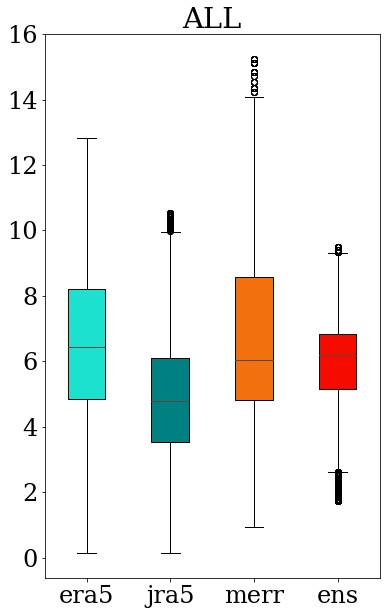

In [153]:
for szn in data.keys():
    fig, ax = plt.subplots(figsize=(6, 10))
    bp = ax.boxplot(data[szn], whis=1.5, patch_artist=True)
    ax.set_xticklabels(df.drop(columns='obs').columns)
    ax.set_title(szn)
    for patch, color in zip(bp['boxes'], palette[:4]):
        patch.set_facecolor(color)
    for median in bp['medians']:
        median.set_color('#59473C')
    axs[i].set_xticklabels(df.drop(columns='obs').columns)
    plt.savefig('/home/hma000/accomatic-web/tests/plots/agm_poster_acco_plots/%s.png' % acco)
    plt.clf()

TypeError: 'AxesSubplot' object is not subscriptable

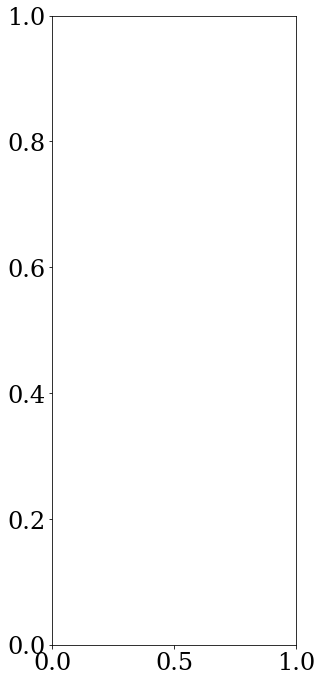

In [152]:
palette = palette[:4]
n_plots = len(data.keys())
fig, axs = plt.subplots(1, n_plots, sharey=True, tight_layout=True, figsize=(5, 10))
for i, szn in zip(range(n_plots), data.keys()):
    axs[i].set_title(szn)
    bp = axs[i].boxplot(data[szn], whis=1.5, patch_artist=True)
    for patch, color in zip(bp['boxes'], palette[:4]):
        patch.set_facecolor(color)
    for median in bp['medians']:
        median.set_color('#59473C')
    axs[i].set_xticklabels(df.drop(columns='obs').columns)

plt.show()

In [ ]:
plt.rcParams["font.size"] = "24"

    
def boot(szn_df, boot_size=10000, consecutive_days_slice=10):

    nrows = range(szn_df.shape[0])
    sims = szn_df.drop(columns='obs').columns
    results = []
    
    # Do a bajillion times per season experiment
    for i in range(boot_size):
        # Select t consecutive days 
        ix = random.randint(nrows.start, nrows.stop-consecutive_days_slice)
        a = szn_df.iloc[ix:ix+consecutive_days_slice, :]
        row = [] 
        for sim in (sims):
            row.append(stats['RMSE'](a.obs, a[sim]))
            # row = [ VAL, VAL, VAL, VAL ]
        results.append(row)
        # results = [ [ VAL, VAL, VAL, VAL ], [ VAL, VAL, VAL, VAL ], ... ]

    results = pd.DataFrame(results, columns = sims) 
    #results = results.rank(axis=1, method="max").astype(int)
    results = results.to_numpy()
            
    # (4, 1000)
    # (sim, runs)
    return results

time_code_months = {
    "ALL": [1,2,3,4,5,6,7,8,9,10,11,12],
    "DJF": [1, 2, 12],
    "MAM": [3, 4, 5],
    "JJA": [6, 7, 8],
    "SON": [9, 10, 11],
    "FREEZE": [9, 10, 11, 12, 1, 2, 3, 4],
    "THAW": [5, 6, 7, 8],
}

df = df.set_index(pd.to_datetime(df.index))

data = {}
for szn in time_code_months.keys():
    szn_df = df[df.index.month.isin(time_code_months[szn])]
    data[szn] = boot(szn_df)


# TERRAIN TYPE BOX PLOT